# Sklearn Toolkit and Pipeline Demonstation

This document aims to give a brief tutorial to share some of the methods I learned during Professor Andrew Delong's course: COMP6321 (Machine Learning)

* Part 1 — Default Models, Dummy Classifiers, and Cross Validation
* Part 2 — Hyperparmeter tuning using grid and random search
* Part 3 — Sklearn Pipeline
* Part 4 — Custom Classifiers and Estimators

To use: get data from: https://www.kaggle.com/c/ashrae-energy-prediction/data. Download all files and put in a folder called data.

In [43]:
import glob
import scipy
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.exceptions import NotFittedError
import sklearn.pipeline

from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split

from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [3]:
files = glob.glob("data/*.csv")
data = {}
for f in tqdm(files):
    name = f.split('\\')[1].split('.')[0]
    data[name] = pd.read_csv(f)

print('Downloaded data:')
for f in files: print('\t{}'.format(f.split('\\')[1].split('.')[0]))


Downloaded data:
	building_metadata
	sample_submission
	test
	train
	weather_test
	weather_train


## Problem Setup:

For this demonstration, the "problem" has been reimagined to be a classification problem. This document aims to answer: if you have a year's worth of energy use, building area, and climate conditions, can we estimate the primary building use type?

In [4]:
# Aggrigate data by building
train_set = data['train'].groupby('building_id')['meter_reading'].sum().to_frame().reset_index()

# Organize Weather Data by min, max, mean
weather = data['weather_train'][['site_id', 'timestamp', 'air_temperature']]
weather_max = weather.groupby('site_id')['air_temperature'].max().to_frame().rename(columns={'air_temperature': 'temp_max'})
weather_mean = weather.groupby('site_id')['air_temperature'].mean().to_frame().rename(columns={'air_temperature': 'temp_mean'})
weather_min = weather.groupby('site_id')['air_temperature'].min().to_frame().rename(columns={'air_temperature': 'temp_min'})
weather = pd.concat([weather_max, weather_mean, weather_min], axis=1).reset_index()

# Exclude year and floors due to excess missing data
building = data['building_metadata'][['site_id', 'building_id', 'primary_use', 'square_feet']]

#Merge Data
merged_data = pd.merge(train_set, building, on='building_id')
merged_data = pd.merge(merged_data, weather, on=['site_id'])
merged_data = merged_data[['primary_use', 'square_feet', 'meter_reading', 'temp_max', 'temp_mean', 'temp_min']]
merged_data

,primary_use,square_feet,meter_reading,temp_max,temp_mean,temp_min
0,Education,7432,1.286461e+06,36.1,22.836021,1.7
1,Education,2720,6.576176e+05,36.1,22.836021,1.7
2,Education,5376,1.278194e+05,36.1,22.836021,1.7
3,Education,23685,2.069071e+06,36.1,22.836021,1.7
4,Education,116607,8.578074e+06,36.1,22.836021,1.7
...,...,...,...,...,...,...
1444,Entertainment/public assembly,19619,5.570443e+04,33.9,9.357618,-23.9
1445,Education,4298,3.525474e+04,33.9,9.357618,-23.9
1446,Entertainment/public assembly,11265,2.684063e+04,33.9,9.357618,-23.9
1447,Lodging/residential,29775,1.397959e+06,33.9,9.357618,-23.9


In [5]:
print(merged_data['primary_use'].value_counts())

Education                        549
Office                           279
Entertainment/public assembly    184
Public services                  156
Lodging/residential              147
Other                             25
Healthcare                        23
Parking                           22
Warehouse/storage                 13
Manufacturing/industrial          12
Retail                            11
Services                          10
Technology/science                 6
Food sales and service             5
Utility                            4
Religious worship                  3
Name: primary_use, dtype: int64


For the models below to work, the low-frequency sets were excluded from the test set. Perhaps the errors associated with including them could be resolved in a future revision.

In [6]:
use_type_count = merged_data['primary_use'].value_counts() # Get value counts
remove = use_type_count[use_type_count<10].index.tolist() # Get list of building types with less than 10 representations
trimmed = merged_data[~merged_data['primary_use'].isin(remove)] # Remove those buildings from datset

Our final step is to split our data into a training set and testing set

In [16]:
# Assign X and y features
included_features = ['meter_reading', 'square_feet', 'temp_max', 'temp_mean', 'temp_min']
X = trimmed[included_features]
y = trimmed[['primary_use']].values.ravel()

#Split train test using the sklearn train_test_split
X_train, X_test, y_train, y_test = train_test_split(X ,y, train_size=0.8, random_state=0)

### *Part 1 &mdash; Default Models, Dummy Classifiers, and Cross Validation*

The sklearn toolbox offers a variety of dummy models, which employ simple strategies to baseline against your models. In the example below, we will compare an unoptimized decision tree with the simple strategy of guessing the most common building type.

https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html

In [8]:
# Baseline 
dum = DummyClassifier(strategy='most_frequent')
dum.fit(X_train,y_train)

print('The DummyClassifier has a score of\n {:0.1f}% training set\n {:0.1f}% testing set'.format(
    dum.score(X_train, y_train)*100, dum.score(X_test, y_test)*100
))

# Decision tree using default hyperparameters
dt = DecisionTreeClassifier(random_state=1)
dt.fit(X_train,y_train)

print('')
print('The DecisionTreeClassifier has a score of\n {:0.1f}% training set\n {:0.1f}% testing set'.format(
    dt.score(X_train, y_train)*100, dt.score(X_test, y_test)*100
))

The DummyClassifier has a score of
 37.9% training set
 40.1% testing set

The DecisionTreeClassifier has a score of
 100.0% training set
 41.5% testing set


To fix this, we need to tune the hyperparameters of the model to avoid overfitting and make the model more robust. For example, one parameter in a decision tree is the max depth. Therefore, we could suspect that our trained decision tree is too deep, hence the overfitting.

In [9]:
# Depth of decision tree when max_depth is not trained
dt.get_depth()

25

In [10]:
for depth in range(2,10):
    print('for max_depth={}:  score on test data:{:0.1%}'.format(
        depth, DecisionTreeClassifier(max_depth=depth, random_state=0).fit(X_train, y_train).score(X_test, y_test)
    ))

for max_depth=2:  score on test data:45.3%
for max_depth=3:  score on test data:46.7%
for max_depth=4:  score on test data:46.7%
for max_depth=5:  score on test data:47.0%
for max_depth=6:  score on test data:46.0%
for max_depth=7:  score on test data:48.8%
for max_depth=8:  score on test data:46.7%
for max_depth=9:  score on test data:46.3%


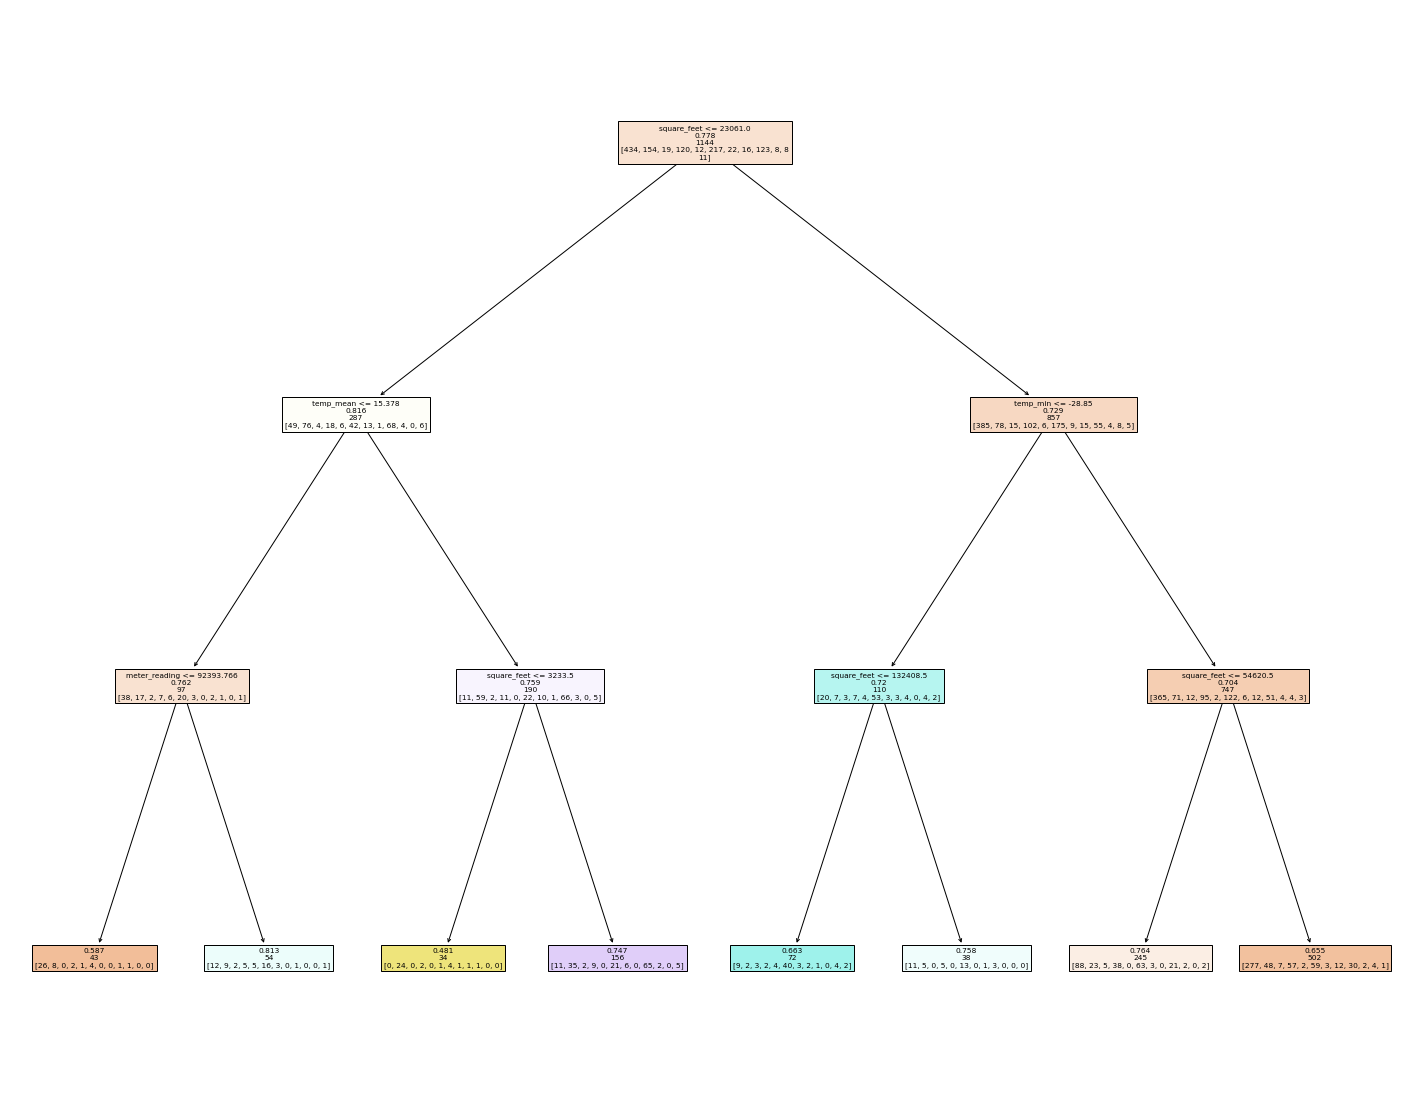

In [120]:
dt = DecisionTreeClassifier(random_state=1, max_depth=3).fit(X_train, y_train)
fig = plt.figure(figsize=(25,20))

sklearn.tree.plot_tree(dt, feature_names=included_features, label='none', filled=True);

Note: excerpt from lab 7 from Professor Andrew Delong's course: COMP6321 (Machine Learning), Concordia University 2021
<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>

As a rule, data marked as a "test set" should ALMOST NEVER be used for training, or even for model selection. All modeling choices (parameters, best model) must be made based on training data, ONLY. Otherwise you will very likely fool yourself, or others, into thinking your system will perform well on held-out data when it will not. 

"Peeking" at the test data, directly or indirectly, or even measuring the performance on test data too often, is even considered cheating. In fact, at least <a href="https://www.cio.com/article/2935233/baidu-fires-researcher-involved-in-ai-contest-flap.html">one well-known machine learning scientist was <b>fired from his job</b></a> for trying to tune hyperparameters directly to the test data.


***K*-fold cross validation** is a specific procedure for estimating held-out performance using only the training set. It creates *K* different (training, validation) splits and then averaging the validation performance measured on each one. (Beware that scikit-learn's [desciption of cross validation](https://scikit-learn.org/stable/modules/cross_validation.html#k-fold) sometimes refers to the *K* individual validation sets as "test sets" so this can be confusing since they are not really validation sets.) The *K*-fold cross validation procedure is depicted below. When there are *K* splits the result is *K* different performance estimates, one for each of the held-out folds.
<img src="img/grid_search_cross_validation.png" width="550">

(Image source: https://scikit-learn.org/stable/modules/cross_validation.html)

Note that the "test data" depicted above is not needed for the cross validation procedure itself, and is only used as an (optional) final performance evaluation, after the model selection procedure.

Use the **[sklearn.metrics.accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)** function or, equivalently, the **[score](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier.score)** method of your *DecisionTreeClassifier* to compute the training and testing accuracies.

Use the **[sklearn.model_selection.cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html)** function to do the cross validation. It will return an array of *K* values, so you need to average them to get an overall estimate.

<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>

For time based data you can also use a time series split rather than a k-fold split to better simulate time series data.

<img src="img/kFold.png" width="550">
<img src="img/TimeSeries.png" width="550">

image source(https://datascience.stackexchange.com/questions/41378/how-to-apply-stacking-cross-validation-for-time-series-data)

In [10]:
# Using k-fold cross validation on test data

# Create DT classifier using optimized max depth (found previously)
dt = DecisionTreeClassifier(random_state=1, max_depth=7).fit(X_train, y_train)

# Print score on training and testing set
print('The training accuracy is: {:.1%}'.format(dt.score(X_train, y_train)))
print('The testing accuracy is: {:.1%}'.format(dt.score(X_test, y_test)))

# Loop through range of train test split to observe performance.
for i in range(2,7):
    accuracy = sklearn.model_selection.cross_val_score(dt, X_train, y_train, cv=i)
    print('held-out accuracy ({}-fold): {:.1%}'.format(i, np.mean(accuracy)))

The training accuracy is: 60.8%
The testing accuracy is: 48.8%
held-out accuracy (2-fold): 42.7%
held-out accuracy (3-fold): 43.6%
held-out accuracy (4-fold): 45.2%
held-out accuracy (5-fold): 44.1%
held-out accuracy (6-fold): 46.3%


From this we can conclude that using the cross validation give us a reliable esitmate of how our model with act on our testing set.

### *Part 2 &mdash; Hyperparmeter tuning using random search*

In [60]:
grid = {
    'max_depth': range(100),
    'criterion': ['gini', 'entropy'],
}

gs_dt = sklearn.model_selection.GridSearchCV(
    estimator=dt, 
    param_grid=grid,
    n_jobs=8,
    cv=5, 
    verbose=1
).fit(X_train, y_train)

pd.DataFrame(gs_dt.cv_results_).sort_values('mean_test_score', ascending=False)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.0s
[Parallel(n_jobs=8)]: Done 960 tasks      | elapsed:    4.7s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    4.8s finished


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
106,0.010202,0.000400,0.002200,0.000401,entropy,6,"{'criterion': 'entropy', 'max_depth': 6}",0.458515,0.480349,0.502183,0.502183,0.491228,0.486892,0.016337,1
104,0.008704,0.000396,0.002208,0.000410,entropy,4,"{'criterion': 'entropy', 'max_depth': 4}",0.427948,0.489083,0.493450,0.475983,0.486842,0.474661,0.024055,2
107,0.012003,0.001263,0.002601,0.000491,entropy,7,"{'criterion': 'entropy', 'max_depth': 7}",0.419214,0.475983,0.480349,0.502183,0.491228,0.473791,0.028763,3
103,0.008003,0.001097,0.002400,0.000490,entropy,3,"{'criterion': 'entropy', 'max_depth': 3}",0.436681,0.471616,0.471616,0.493450,0.482456,0.471164,0.019045,4
5,0.006801,0.000752,0.002401,0.000489,gini,5,"{'criterion': 'gini', 'max_depth': 5}",0.423581,0.471616,0.489083,0.475983,0.469298,0.465912,0.022245,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,0.008641,0.000776,0.002395,0.000492,gini,87,"{'criterion': 'gini', 'max_depth': 87}",0.349345,0.379913,0.427948,0.401747,0.355263,0.382843,0.029268,117
15,0.009803,0.001469,0.002601,0.000489,gini,15,"{'criterion': 'gini', 'max_depth': 15}",0.344978,0.401747,0.410480,0.393013,0.359649,0.381973,0.025269,197
19,0.008602,0.000800,0.002603,0.000491,gini,19,"{'criterion': 'gini', 'max_depth': 19}",0.349345,0.384279,0.406114,0.401747,0.355263,0.379350,0.023335,198
0,0.004601,0.000490,0.000000,0.000000,gini,0,"{'criterion': 'gini', 'max_depth': 0}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,200


<img src="img/gridsearchvsrandomsearch.png" width="550">

image source (https://blog.usejournal.com/a-comparison-of-grid-search-and-randomized-search-using-scikit-learn-29823179bc85?gi=f8c3537f6b61)

In [61]:
rf = RandomForestClassifier()

dist = {
    'max_depth': range(1, 100),
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

cv_rf = sklearn.model_selection.RandomizedSearchCV(
    estimator=rf,
    param_distributions=dist,
    verbose=1,
    cv=5, n_iter=100, n_jobs=8
).fit(X_train, y_train)
pd.DataFrame(cv_rf.cv_results_).sort_values('mean_test_score', ascending=False)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    9.2s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:   20.7s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   23.5s finished


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_max_depth,param_bootstrap,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
73,0.261724,0.009222,0.019003,0.003347,sqrt,6,True,"{'max_features': 'sqrt', 'max_depth': 6, 'boot...",0.484716,0.515284,0.502183,0.519651,0.482456,0.500858,0.015246,1
16,0.237051,0.008650,0.016804,0.000401,log2,6,False,"{'max_features': 'log2', 'max_depth': 6, 'boot...",0.497817,0.493450,0.502183,0.528384,0.473684,0.499104,0.017588,2
17,0.263460,0.012280,0.018802,0.000751,sqrt,7,False,"{'max_features': 'sqrt', 'max_depth': 7, 'boot...",0.497817,0.510917,0.493450,0.524017,0.469298,0.499100,0.018343,3
52,0.290267,0.007861,0.017204,0.000398,sqrt,8,True,"{'max_features': 'sqrt', 'max_depth': 8, 'boot...",0.471616,0.497817,0.515284,0.515284,0.482456,0.496491,0.017458,4
24,0.311491,0.009752,0.019205,0.001168,log2,9,False,"{'max_features': 'log2', 'max_depth': 9, 'boot...",0.441048,0.515284,0.524017,0.515284,0.478070,0.494741,0.031183,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31,0.380685,0.013634,0.021204,0.000979,log2,82,False,"{'max_features': 'log2', 'max_depth': 82, 'boo...",0.384279,0.458515,0.467249,0.458515,0.438596,0.441431,0.030082,96
5,0.443901,0.012922,0.021405,0.001498,sqrt,56,False,"{'max_features': 'sqrt', 'max_depth': 56, 'boo...",0.397380,0.467249,0.462882,0.449782,0.429825,0.441423,0.025580,97
3,0.398698,0.015507,0.023406,0.001021,sqrt,38,False,"{'max_features': 'sqrt', 'max_depth': 38, 'boo...",0.406114,0.471616,0.454148,0.436681,0.434211,0.440554,0.021868,98
4,0.429703,0.028605,0.026406,0.002940,sqrt,40,False,"{'max_features': 'sqrt', 'max_depth': 40, 'boo...",0.410480,0.471616,0.467249,0.432314,0.421053,0.440542,0.024617,99


<img src="img/uniformvsreciprocal.png" width="400">

In [64]:
svc = sklearn.svm.SVC()
dist = {
    'C': scipy.stats.uniform(1, 1000),
    'gamma': scipy.stats.reciprocal(1, 1000),
}

cv_svc = sklearn.model_selection.RandomizedSearchCV(
    estimator=svc,
    param_distributions=dist,
    verbose=1,
    cv=5, n_iter=100, n_jobs=8
).fit(X_train, y_train)
pd.DataFrame(cv_svc.cv_results_).sort_values('mean_test_score', ascending=False)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.7s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    8.1s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:   18.8s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   21.5s finished


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.342471,0.021902,0.030008,0.003406,136.462982,4.830727,"{'C': 136.46298203233297, 'gamma': 4.830727465...",0.379913,0.379913,0.379913,0.379913,0.377193,0.379369,0.001088,1
63,0.312469,0.004885,0.023005,0.000633,175.493212,73.155444,"{'C': 175.49321235564753, 'gamma': 73.15544381...",0.379913,0.379913,0.379913,0.379913,0.377193,0.379369,0.001088,1
73,0.331380,0.023648,0.024205,0.001939,668.313428,704.591302,"{'C': 668.3134281109934, 'gamma': 704.59130183...",0.379913,0.379913,0.379913,0.379913,0.377193,0.379369,0.001088,1
72,0.317174,0.014827,0.023205,0.000400,229.493879,87.470525,"{'C': 229.49387941136035, 'gamma': 87.47052534...",0.379913,0.379913,0.379913,0.379913,0.377193,0.379369,0.001088,1
71,0.334979,0.046755,0.024205,0.001601,798.000285,696.489342,"{'C': 798.0002849108292, 'gamma': 696.48934155...",0.379913,0.379913,0.379913,0.379913,0.377193,0.379369,0.001088,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30,0.329874,0.052675,0.024606,0.004225,789.543265,1.874759,"{'C': 789.5432649974364, 'gamma': 1.8747594270...",0.379913,0.379913,0.379913,0.379913,0.377193,0.379369,0.001088,1
29,0.331874,0.029226,0.024205,0.003430,735.210876,373.703486,"{'C': 735.2108762397248, 'gamma': 373.70348638...",0.379913,0.379913,0.379913,0.379913,0.377193,0.379369,0.001088,1
28,0.314480,0.006531,0.023605,0.001357,782.750731,1.558416,"{'C': 782.7507308322366, 'gamma': 1.5584155464...",0.379913,0.379913,0.379913,0.379913,0.377193,0.379369,0.001088,1
27,0.317698,0.012802,0.023805,0.000980,901.467384,833.225149,"{'C': 901.4673835365061, 'gamma': 833.22514859...",0.379913,0.379913,0.379913,0.379913,0.377193,0.379369,0.001088,1


### *Part 3 &mdash; Sklearn Pipeline*

<img src="img/pipeline.jpg" width="500" align="left">

In [34]:
svcs = sklearn.pipeline.Pipeline(steps=[
    ('scaler', sklearn.preprocessing.StandardScaler()),
    ('model',  sklearn.svm.SVC())
])

In [35]:
sklearn.set_config(display='diagram')
svcs

Pipeline(steps=[('scaler', StandardScaler()), ('model', SVC())])

In [36]:
def print_param_names(estimator):
    for name in estimator.get_params():
        print(name)

print_param_names(svcs)

memory
steps
verbose
scaler
model
scaler__copy
scaler__with_mean
scaler__with_std
model__C
model__break_ties
model__cache_size
model__class_weight
model__coef0
model__decision_function_shape
model__degree
model__gamma
model__kernel
model__max_iter
model__probability
model__random_state
model__shrinking
model__tol
model__verbose


In [37]:
dist = {
    'model__C': scipy.stats.reciprocal(1, 100),
    'model__gamma': scipy.stats.reciprocal(1, 100),
}
cv_svcs = sklearn.model_selection.RandomizedSearchCV(
    estimator=svcs,
    param_distributions=dist,
    verbose=1,
    cv=5, n_iter=100, n_jobs=8
).fit(X_train, y_train)
pd.DataFrame(cv_svcs.cv_results_).sort_values('mean_test_score', ascending=False)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.5s
[Parallel(n_jobs=8)]: Done 256 tasks      | elapsed:    6.8s
[Parallel(n_jobs=8)]: Done 485 out of 500 | elapsed:   10.2s remaining:    0.2s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   10.4s finished


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__C,param_model__gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
73,0.101028,0.005313,0.011803,0.001167,1.012429,42.028393,"{'model__C': 1.012428920940535, 'model__gamma'...",0.480349,0.462882,0.528384,0.497817,0.464912,0.486869,0.024262,1
55,0.157677,0.007589,0.016403,0.000800,1.05094,97.313065,"{'model__C': 1.0509396473940422, 'model__gamma...",0.502183,0.454148,0.532751,0.506550,0.438596,0.486846,0.035008,2
3,0.100633,0.010714,0.009401,0.000801,21.436115,1.103092,"{'model__C': 21.436114754229926, 'model__gamma...",0.449782,0.475983,0.510917,0.515284,0.478070,0.486007,0.024304,3
69,0.100358,0.006069,0.011203,0.000401,1.050508,41.636475,"{'model__C': 1.050508229629029, 'model__gamma'...",0.480349,0.458515,0.528384,0.502183,0.460526,0.485992,0.026437,4
52,0.083017,0.009616,0.008602,0.000491,8.73649,1.48309,"{'model__C': 8.736489737295699, 'model__gamma'...",0.475983,0.471616,0.502183,0.515284,0.460526,0.485118,0.020355,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,0.111626,0.004080,0.009202,0.000400,57.705592,26.38153,"{'model__C': 57.7055918868241, 'model__gamma':...",0.467249,0.441048,0.475983,0.449782,0.399123,0.446637,0.026776,96
53,0.137754,0.007561,0.012202,0.000400,67.802727,59.191001,"{'model__C': 67.80272722485824, 'model__gamma'...",0.441048,0.423581,0.475983,0.475983,0.412281,0.445775,0.026313,97
80,0.120826,0.011307,0.010603,0.000490,45.919654,38.761948,"{'model__C': 45.91965437848883, 'model__gamma'...",0.441048,0.427948,0.489083,0.458515,0.412281,0.445775,0.026457,98
26,0.140484,0.007060,0.012202,0.000400,89.361473,51.736778,"{'model__C': 89.36147303520998, 'model__gamma'...",0.432314,0.432314,0.480349,0.471616,0.412281,0.445775,0.025874,98


In [62]:
cv_svcs.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', SVC(C=1.012428920940535, gamma=42.028393081163635))])

In [65]:
models = [gs_dt, cv_rf, cv_svc, cv_svcs]
names = ['dt', 'rf', 'svc', 'svcs']


print('The results are:')

print('{}:\ttrain acc:{:0.1%} \t test acc:{:0.1%}'.format(
    'dum', dum.score(X_train, y_train), dum.score(X_test, y_test)
))

for model, name in zip(models, names):
    model.best_estimator_.fit(X_train, y_train)
    print('{}:\ttrain acc:{:0.1%} \t test acc:{:0.1%}'.format(
        name, model.score(X_train, y_train), model.score(X_test, y_test)
    ))

The results are:
dum:	train acc:37.9% 	 test acc:40.1%
dt:	train acc:55.1% 	 test acc:49.1%
rf:	train acc:57.3% 	 test acc:53.7%
svc:	train acc:100.0% 	 test acc:40.1%
svcs:	train acc:57.1% 	 test acc:50.2%


In [85]:
# Based on tutorial: https://www.youtube.com/watch?v=8gLewErTU24
def plot_conf_matix(y_true, y_pred, plot_title=None):
    """
    Creates heatmap using 
    """
    labels = sklearn.utils.multiclass.unique_labels(y_true)
    column = [f'{label}' for label in labels]
    indicies = [f'{label}' for label in labels]
    cm = sklearn.metrics.confusion_matrix(y_test, y_pred, normalize=cm_normalize)
    table = pd.DataFrame(cm, columns=column, index=indicies)
    sns.heatmap(table, annot=True, fmt='d', cmap='viridis')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(plot_title)

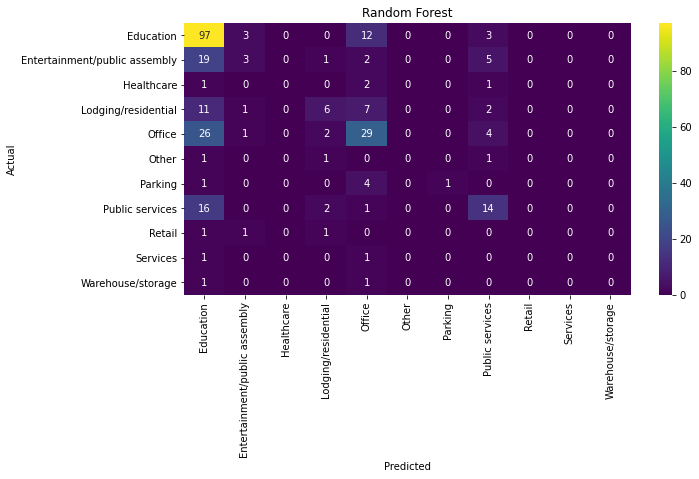

In [98]:
plt.figure(figsize=(10,5))
y_pred = cv_rf.best_estimator_.fit(X_train, y_train).predict(X_test)
plot_conf_matix(y_test, y_pred, plot_title='Random Forest');

### *Part 4 &mdash; Custom Classifiers and Estimators*

For this section, we will write a custom transformer and a custom estimator. You may be thinking up until now that this looks good, but you require special preprocessing and models based on your expertise in the data, so these pre-made sklearn models will not work. There is a way to integrate your particular needs into a sklearn style model. The advantage to this is that you can rapidly compare your models to a vast library of these pre-made models, and you can take advantage of the sklearn tools, such as random search

To see a more formal example you can look at the source code of the standard scaler: https://github.com/automl/paramsklearn/blob/master/ParamSklearn/implementations/StandardScaler.py

For the transformer below, we image a situation where we are unsure if the weather inputs are acually useful. Perhaps what would be better if we just designate the location, and we allow the models simply to understand the some buildings are in the same location, rather than trying to derive mening from the max, min, and mean weather conditions.

In [99]:
class pre_processer(BaseEstimator, TransformerMixin):
    """
    This custom transformer will any of the following depending on the input
        1. Do nothing to the input features
        2. Normalize all the input features base on an sklearn style pre-processer
        3. Encode the categorized weather data into a unique encoder using a sklearn style encoder
        4. Both encode weather data and normalize non-weather data
    """

    def __init__(self, normalizer=None, encoder=None):
        """
        This function is reqired and can be used for the transfomer inputs.
        ***Important note: make sure your class names are the same as your input names,
            otherwise the random search will not work.
        """
        self.normalizer = normalizer
        self.encoder = encoder
        return None
    
    def fit(self, x, y=None):
        """
        This function is reqired
        """
        if self.encoder is not None:
            x_left = x.iloc[:,0:2]
            x_right = (x.iloc[:, 2] * x.iloc[:, 3] * x.iloc[:, 4]).to_frame()
            self.encoder.fit(x_right)
            if self.normalizer is not None:
                self.normalizer.fit(x_left)
        elif self.normalizer is not None:          
            self.normalizer.fit(x)
        return self

    
    def transform(self, x, y=None):
        """
        This function is reqired
        """
        if self.encoder is not None:
            x_left = x.iloc[:,0:2]
            x_right = (x.iloc[:, 2] * x.iloc[:, 3] * x.iloc[:, 4]).to_frame()
            x_right = pd.DataFrame(self.encoder.transform(x_right))
            if self.normalizer is not None:
                x_left = pd.DataFrame(self.normalizer.transform(x_left) )
            x_left.reset_index(drop=True, inplace=True)
            x_right.reset_index(drop=True, inplace=True)
            return pd.concat([x_left, x_right], ignore_index=True, axis=1)
        elif self.normalizer is not None:          
            return pd.DataFrame(self.normalizer.transform(x))
        else:
            return x
        
        
    def inverse_transform(self, X, y=None):
        """
        If you wanted you can create an inverse transform 
        but it is not requred for the sklearn pipeline.
        """
        return None

In [100]:
pre = pre_processer(
    normalizer=sklearn.preprocessing.StandardScaler(),
    encoder=OrdinalEncoder()
)

pre.fit_transform(X_train)
# Note, fit_transform is not a function that we wrote, but we can still take 
# advantage of it becuase it is an sklearn style classifier

,0,1,2
0,-0.029349,-0.253839,1.0
1,-0.035644,-0.299195,0.0
2,-0.035935,-0.755706,9.0
3,-0.035308,-0.118857,0.0
4,-0.035061,0.073133,6.0
...,...,...,...
1139,-0.033885,-0.091068,3.0
1140,-0.035943,-0.779623,12.0
1141,-0.025827,0.616199,4.0
1142,-0.035858,-0.034194,6.0


In [101]:
svcspecialboi = sklearn.pipeline.Pipeline(steps=[
    ('pre_processing', pre_processer()),
    ('model',  sklearn.svm.SVC())
])

In [102]:
print_param_names(svcspecialboi)

memory
steps
verbose
pre_processing
model
pre_processing__encoder
pre_processing__normalizer
model__C
model__break_ties
model__cache_size
model__class_weight
model__coef0
model__decision_function_shape
model__degree
model__gamma
model__kernel
model__max_iter
model__probability
model__random_state
model__shrinking
model__tol
model__verbose


In [103]:
dist = {
    'pre_processing__encoder': [None, LabelEncoder(), OrdinalEncoder()],
    'pre_processing__normalizer': [None, sklearn.preprocessing.StandardScaler()],
    'model__C': scipy.stats.reciprocal(1, 100),
    'model__gamma': scipy.stats.reciprocal(1, 100)
}
cv_svcspecialboi = sklearn.model_selection.RandomizedSearchCV(
    estimator=svcspecialboi,
    param_distributions=dist,
    verbose=1,
    cv=5, n_iter=100, n_jobs=8
).fit(X_train, y_train)
pd.DataFrame(cv_svcspecialboi.cv_results_).sort_values('mean_test_score', ascending=False)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.7s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    9.1s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:   17.2s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   18.9s finished
C:\Users\conco\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\conco\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__C,param_model__gamma,param_pre_processing__encoder,param_pre_processing__normalizer,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
67,0.190441,0.006282,0.023606,0.001624,1.318361,61.286598,LabelEncoder(),StandardScaler(),"{'model__C': 1.3183605272950984, 'model__gamma...",0.489083,0.454148,0.541485,0.497817,0.451754,0.486857,0.032898,1
51,0.082018,0.009275,0.011002,0.001097,6.491068,1.730692,None,StandardScaler(),"{'model__C': 6.491068319111257, 'model__gamma'...",0.471616,0.471616,0.502183,0.519651,0.451754,0.483364,0.024274,2
54,0.153433,0.036224,0.016004,0.001096,54.697099,1.044616,OrdinalEncoder(),StandardScaler(),"{'model__C': 54.69709944719909, 'model__gamma'...",0.467249,0.449782,0.515284,0.506550,0.473684,0.482510,0.024633,3
71,0.075216,0.003487,0.012403,0.000800,1.934347,4.529551,OrdinalEncoder(),StandardScaler(),"{'model__C': 1.9343466259551978, 'model__gamma...",0.475983,0.454148,0.519651,0.502183,0.460526,0.482498,0.024887,4
53,0.134828,0.015358,0.013803,0.002227,35.841937,1.245458,LabelEncoder(),StandardScaler(),"{'model__C': 35.84193677898218, 'model__gamma'...",0.467249,0.449782,0.510917,0.502183,0.473684,0.480763,0.022630,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,0.314273,0.014638,0.025406,0.001357,14.219168,13.609232,OrdinalEncoder(),None,"{'model__C': 14.21916779107645, 'model__gamma'...",0.379913,0.379913,0.379913,0.379913,0.377193,0.379369,0.001088,50
23,0.345940,0.050258,0.029307,0.004192,35.703741,41.095796,OrdinalEncoder(),None,"{'model__C': 35.70374132141676, 'model__gamma'...",0.379913,0.379913,0.379913,0.379913,0.377193,0.379369,0.001088,50
66,0.316470,0.007763,0.023805,0.000749,5.721729,3.149448,None,None,"{'model__C': 5.721729108296365, 'model__gamma'...",0.379913,0.379913,0.379913,0.379913,0.377193,0.379369,0.001088,50
20,0.346076,0.023306,0.028406,0.003557,8.411078,62.164012,OrdinalEncoder(),None,"{'model__C': 8.411077709447744, 'model__gamma'...",0.379913,0.379913,0.379913,0.379913,0.377193,0.379369,0.001088,50


Now we will write a sklearn estimator. Here you

In [104]:
def check_size(guess_num, length):
        if guess_num > length:
            raise ValueError(
                'The number needs to be less than the unique values of the training set ({})'.format(length))

class silly_estimator(BaseEstimator, ClassifierMixin):
    """
    This estimator is not acually that usefull. its only purpose is to show a relatively simple predictor.
    It simply takes a list of all unique y outputs and selects which one to use base on the guess_number
    inputer hyperparameter. It does not do anything with the x inputs.
    """
    def __init__(self, guess_number=0):
        self.guess_number = guess_number
        return None
        
    def fit(self, x, y):
        self.options = np.unique(np.array(y))
        self.length = len(self.options)
        check_size(self.guess_number, self.length)
        return self
    
    def predict(self, x):
        length, _ = x.shape
        guess = self.options[self.guess_number]
        return np.full((length,), guess).tolist()
    
    def score(self, x, y):
        """
        score is reqired so the random search knows what is the best estimator
        """
        y_pred = self.predict(x)
        return sklearn.metrics.accuracy_score(y, y_pred)

In [109]:
silly = silly_estimator(guess_number=0)
silly.fit(X_train, y_train).predict(X_test)[0:10] 

['Education',
 'Education',
 'Education',
 'Education',
 'Education',
 'Education',
 'Education',
 'Education',
 'Education',
 'Education']

In [110]:
dist = {
    'guess_number': range(12),
}
cv_silly = sklearn.model_selection.RandomizedSearchCV(
    error_score=0,
    estimator=sil,
    param_distributions=dist,
    verbose=1,
    cv=5, n_iter=100, n_jobs=8
).fit(X_train, y_train)
pd.DataFrame(cv_silly.cv_results_).sort_values('mean_test_score', ascending=False)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


C:\Users\conco\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:278: UserWarning: The total space of parameters 12 is smaller than n_iter=100. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  60 out of  60 | elapsed:    0.0s finished


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_guess_number,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.001000,6.314305e-04,0.000400,0.000490,0,{'guess_number': 0},0.379913,0.379913,0.379913,0.379913,0.377193,0.379369,0.001088,1
5,0.000600,4.899407e-04,0.000400,0.000490,5,{'guess_number': 5},0.192140,0.187773,0.187773,0.187773,0.192982,0.189688,0.002361,2
1,0.001000,1.124365e-06,0.000600,0.000490,1,{'guess_number': 1},0.135371,0.135371,0.135371,0.131004,0.135965,0.134617,0.001821,3
8,0.001001,6.325614e-04,0.000200,0.000400,8,{'guess_number': 8},0.104803,0.109170,0.109170,0.109170,0.105263,0.107516,0.002032,4
3,0.000999,1.302385e-06,0.000000,0.000000,3,{'guess_number': 3},0.104803,0.104803,0.104803,0.104803,0.105263,0.104895,0.000184,5
6,0.001001,1.548069e-06,0.000199,0.000399,6,{'guess_number': 6},0.017467,0.021834,0.021834,0.017467,0.017544,0.019229,0.002127,6
2,0.000800,3.999959e-04,0.000400,0.000490,2,{'guess_number': 2},0.017467,0.017467,0.013100,0.017467,0.017544,0.016609,0.001755,7
7,0.001000,4.101908e-07,0.000200,0.000400,7,{'guess_number': 7},0.013100,0.013100,0.017467,0.013100,0.013158,0.013985,0.001741,8
4,0.001000,6.322592e-04,0.000400,0.000490,4,{'guess_number': 4},0.008734,0.008734,0.008734,0.013100,0.013158,0.010492,0.002153,9
11,0.001000,5.091228e-07,0.000401,0.000491,11,{'guess_number': 11},0.013100,0.008734,0.008734,0.008734,0.008772,0.009615,0.001743,10


In [111]:
class multi_model(BaseEstimator, ClassifierMixin):
    """
    This custom predictor takes up to 3 sklearn classifiers, fits them all to the training data and predicts
    the most common prediction between the three predictions
    """
    def __init__(self, model1=None, model2=None, model3=None):
        if model1 is None:
            raise ValueError("Model1 is not defined")
        if model2 is None and self.model3 is not None:
            raise ValueError("Define models in order")
        self.model1 = model1
        self.model2 = model2
        self.model3 = model3
        return None
        
    def fit(self, x, y):
        x_ = x
        y_ = y
        self.model1.fit(x_, y_)
        if self.model2 is not None:
            self.model2.fit(x_, y_)
        if self.model3 is not None:
            self.model3.fit(x_, y_)
        return self
    
    def predict(self, x):
        if self.model1 is None:
            raise ValueError("Model1 is not defined")
        x_ = x
        estimate_model1 = self.model1.predict(x_).reshape(-1,1)
        estimate = estimate_model1
        if self.model2 is not None:
            estimate_model2 = self.model2.predict(x_).reshape(-1,1)
            estimate = np.hstack([estimate_model1, estimate_model2])
        if self.model3 is not None:
            estimate_model3 = self.model3.predict(x_).reshape(-1,1)
            estimate = np.hstack([estimate_model1, estimate_model2, estimate_model3])
        y_pred, _ = scipy.stats.mode(estimate, axis=1)
        return y_pred
    
    def score(self, x, y):
        x_ = x
        y_ = y
        y_pred = self.predict(x_)
        return sklearn.metrics.accuracy_score(y_, y_pred)

In [112]:
custom_predictor = sklearn.pipeline.Pipeline(steps=[
    ('pre_processing', pre_processer()),
    ('model',  multi_model(
        model1=DecisionTreeClassifier(),
        model2=RandomForestClassifier(),
        model3=sklearn.svm.SVC()
    ))
])

In [113]:
sklearn.set_config(display='diagram')
custom_predictor

Pipeline(steps=[('pre_processing', pre_processer()),
                ('model',
                 multi_model(model1=DecisionTreeClassifier(),
                             model2=RandomForestClassifier(), model3=SVC()))])

In [114]:
print_param_names(custom_predictor)

memory
steps
verbose
pre_processing
model
pre_processing__encoder
pre_processing__normalizer
model__model1__ccp_alpha
model__model1__class_weight
model__model1__criterion
model__model1__max_depth
model__model1__max_features
model__model1__max_leaf_nodes
model__model1__min_impurity_decrease
model__model1__min_impurity_split
model__model1__min_samples_leaf
model__model1__min_samples_split
model__model1__min_weight_fraction_leaf
model__model1__presort
model__model1__random_state
model__model1__splitter
model__model1
model__model2__bootstrap
model__model2__ccp_alpha
model__model2__class_weight
model__model2__criterion
model__model2__max_depth
model__model2__max_features
model__model2__max_leaf_nodes
model__model2__max_samples
model__model2__min_impurity_decrease
model__model2__min_impurity_split
model__model2__min_samples_leaf
model__model2__min_samples_split
model__model2__min_weight_fraction_leaf
model__model2__n_estimators
model__model2__n_jobs
model__model2__oob_score
model__model2__ra

In [115]:
dist = {
    'pre_processing__encoder': [None, LabelEncoder(), OrdinalEncoder()],
    'pre_processing__normalizer': [None, sklearn.preprocessing.StandardScaler()],
    
    'model__model1__max_depth': scipy.stats.reciprocal(1, 100),
    
    'model__model2__max_depth': scipy.stats.reciprocal(1, 100),
    'model__model2__max_features': ['sqrt', 'log2'],
    'model__model2__bootstrap': [True, False],
    
    'model__model3__C': scipy.stats.reciprocal(1, 100),
    'model__model3__gamma': scipy.stats.reciprocal(1, 100)
}
cv_custom_predictor = sklearn.model_selection.RandomizedSearchCV(
    estimator=custom_predictor,
    param_distributions=dist,
    verbose=1,
    cv=3, n_iter=500, n_jobs=8
).fit(X_train, y_train.ravel())
pd.DataFrame(cv_custom_predictor.cv_results_).sort_values('mean_test_score', ascending=False)

Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   11.7s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:   26.8s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:   49.0s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:  1.3min
[Parallel(n_jobs=8)]: Done 1500 out of 1500 | elapsed:  1.6min finished


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__model1__max_depth,param_model__model2__bootstrap,param_model__model2__max_depth,param_model__model2__max_features,param_model__model3__C,param_model__model3__gamma,param_pre_processing__encoder,param_pre_processing__normalizer,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
429,0.407808,0.055474,0.058015,0.004969,3.684742,True,10.114805,sqrt,23.562713,43.972396,None,StandardScaler(),{'model__model1__max_depth': 3.684741510885927...,0.479058,0.496063,0.511811,0.495644,0.013375,1
451,0.266583,0.017841,0.053169,0.006652,14.60878,False,6.610781,sqrt,1.077578,1.655452,OrdinalEncoder(),StandardScaler(),{'model__model1__max_depth': 14.60877982593588...,0.463351,0.503937,0.514436,0.493908,0.022028,2
69,0.384793,0.008997,0.054017,0.000007,3.372523,True,28.53478,log2,5.770703,2.308933,None,StandardScaler(),{'model__model1__max_depth': 3.372522658608351...,0.465969,0.490814,0.524934,0.493906,0.024172,3
156,0.330408,0.007041,0.066016,0.005715,2.410719,True,10.125691,sqrt,9.942399,1.698126,LabelEncoder(),StandardScaler(),{'model__model1__max_depth': 2.410719281991683...,0.458115,0.498688,0.522310,0.493038,0.026510,4
248,0.379563,0.015184,0.057869,0.009059,2.171237,False,45.990057,log2,3.006309,1.652131,OrdinalEncoder(),StandardScaler(),"{'model__model1__max_depth': 2.17123653628964,...",0.473822,0.498688,0.503937,0.492149,0.013135,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
398,0.423854,0.008237,0.067116,0.004768,1.053444,True,1.440958,log2,90.327291,53.258189,LabelEncoder(),None,{'model__model1__max_depth': 1.053443925151254...,0.379581,0.380577,0.377953,0.379370,0.001082,492
154,0.399425,0.010533,0.068014,0.004968,96.398819,False,1.043541,sqrt,6.554269,7.127515,None,None,{'model__model1__max_depth': 96.39881883247854...,0.379581,0.380577,0.377953,0.379370,0.001082,492
59,0.437433,0.013673,0.069349,0.002357,47.330764,True,1.117608,sqrt,24.702312,6.245566,None,None,{'model__model1__max_depth': 47.33076373545518...,0.379581,0.380577,0.377953,0.379370,0.001082,492
204,0.428950,0.011147,0.070683,0.008182,4.738383,False,1.120844,sqrt,3.558638,19.980675,None,None,{'model__model1__max_depth': 4.738383397073437...,0.379581,0.380577,0.377953,0.379370,0.001082,492


In [116]:
models = [gs_dt, cv_rf, cv_svc, cv_svcs, cv_silly, cv_custom_predictor]
names = ['dt', 'rf', 'svc', 'svcs', 'silly', 'cust']


print('The results are:')

print('{}:\ttrain acc:{:0.1%} \t test acc:{:0.1%}'.format(
    'dum', dum.score(X_train, y_train), dum.score(X_test, y_test)
))

for model, name in zip(models, names):
    model.best_estimator_.fit(X_train, y_train)
    print('{}:\ttrain acc:{:0.1%} \t test acc:{:0.1%}'.format(
        name, model.score(X_train, y_train), model.score(X_test, y_test)
    ))

The results are:
dum:	train acc:37.9% 	 test acc:40.1%
dt:	train acc:55.1% 	 test acc:49.1%
rf:	train acc:57.0% 	 test acc:51.2%
svc:	train acc:100.0% 	 test acc:40.1%
svcs:	train acc:57.1% 	 test acc:50.2%
silly:	train acc:37.9% 	 test acc:40.1%
cust:	train acc:67.6% 	 test acc:51.6%


In [117]:
sklearn.set_config(display='diagram')
cv_custom_predictor.best_estimator_

Pipeline(steps=[('pre_processing', pre_processer(normalizer=StandardScaler())),
                ('model',
                 multi_model(model1=DecisionTreeClassifier(max_depth=3.6847415108859276),
                             model2=RandomForestClassifier(max_depth=10.11480523137786,
                                                           max_features='sqrt'),
                             model3=SVC(C=23.562712941366744,
                                        gamma=43.972395935685284)))])